## Load libraries

In [1]:
# tensorflow backend
from os import environ
environ['KERAS_BACKEND'] = 'tensorflow'
# vae stuff
from chemvae.vae_utils import VAEUtils
from chemvae import mol_utils as mu
# import scientific py
import numpy as np
import pandas as pd
# rdkit stuff
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import PandasTools
# plotting stuff
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import SVG, display
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

Using TensorFlow backend.
/Users/polinaturiseva/anaconda3/envs/chemvae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:471: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/polinaturiseva/anaconda3/envs/chemvae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:472: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/polinaturiseva/anaconda3/envs/chemvae/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:473: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.in

# Load a model

In [2]:
vae = VAEUtils(directory='../models/zinc_properties')

/Users/polinaturiseva/anaconda3/envs/chemvae/lib/python3.6/site-packages/keras/models.py:245: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Using standarized functions? True
Standarization: estimating mu and std values ...done!


# Using the VAE


## Decode/Encode 

Might not be perfect (it's probabilistic), try it several times.

smiles <i class="fa fa-arrow-right" aria-hidden="true"></i> x <i class="fa fa-arrow-right" aria-hidden="true"></i> z <i class="fa fa-arrow-right" aria-hidden="true"></i> x_r <i class="fa fa-arrow-right" aria-hidden="true"></i> smiles_r  
*This is the solution for the task*

In [79]:
def decode_encode_properties(line_repr):
    smiles = mu.canon_smiles(line_repr)
    X   = vae.smiles_to_hot(smiles,canonize_smiles=True)
    z   = vae.encode(X)
    X_r = vae.decode(z)
#     [0] does nothing, just unpacks list of lists [[qed,SAS,logP]]
    y   = vae.predict_prop_Z(z)[0]
    print(z.shape)
    print('{:20s} : {}'.format('Input',smiles))
    print('{:20s} : {}'.format('Reconstruction',vae.hot_to_smiles(X_r,strip=True)[0]))
    print('{:20s} : {} with norm {:.3f}'.format('Z representation',z.shape, np.linalg.norm(z)))
    print('Properties (qed,SAS,logP):')
    print(f'{y}\n')
    

In [80]:
smiles = ['Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1', 
          'CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C',
         'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1']
for i in smiles:
    decode_encode_properties(i)

(1, 196)
Input                : Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1
Reconstruction       : C(cccc(-](=NC(NC(=O)Nc3ccccc32)cc1
Z representation     : (1, 196) with norm 10.279
Properties (qed,SAS,logP):
[0.72313255 2.4103725  3.1467233 ]

(1, 196)
Input                : CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
Reconstruction       : CN(C)cccc2c(c1)C(=O)C@H]C(=O)OC(C)(C)C
Z representation     : (1, 196) with norm 13.448
Properties (qed,SAS,logP):
[0.81158835 2.2198553  2.4382758 ]

(1, 196)
Input                : COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
Reconstruction       : COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
Z representation     : (1, 196) with norm 13.136
Properties (qed,SAS,logP):
[0.75315255 2.4784982  0.05034626]



**QED - Quantitative Estimation of Drug-likeness**  
Помогает пользователям в оценке качества соединения. QED предоставляет количественную метрику для оценки сходства лекарств. Предоставленные значения могут находиться в диапазоне от нуля (все свойства неблагоприятны) до единицы (все свойства благоприятны). Функции основаны на базовых данных о распределении свойств лекарств. Это позволяет пользователям представлять химические соединения и последующий прогноз чувствительности к лекарственным средствам в терминах logIC50 (мкМ).   
[Source](https://omictools.com/qed-tool)  
**SAS - Synthetic Accessibility Score**  
Score between 1 (easy to make) and 10 (very difficult to make)   
**logP - Water–Octanol partition Coefficient** 
Отношение концентрации химического вещества в октанольной фазе к его концентрации в водной фазе двухфазной системы октанол / вода
[Source](https://omictools.com/qed-tool)

## Decode several attempts

*This is some analysis of the decoding results*

As VAE is a probabilistic tool I have run it several times to get the smaller values of z-distance. Z-distance represents the similarity between target and reconstructed SMILES.

I have managed to get close-to-zero values for 'CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C', 'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1'.  
  
However, for 'Cc1ccc(S2(=O)=NC(=O)Nc3ccccc32)cc1' the distance is still around 5.3 (the most probable result is you rerun will be 4 top results with z-distance around 10).  

However, properties prediction does not depend on reconstruction, only on encoded values, hence, their calculation was not duplicated here

In [47]:
def decode_encode_properties_several_attempts(line_repr, noise=3.0):
    smiles = mu.canon_smiles(line_repr)
    X   = vae.smiles_to_hot(smiles,canonize_smiles=True)
    print('Searching molecules randomly sampled from {:.2f} std (z-distance) from the point'.format(noise))
    df = vae.z_to_smiles(z, decode_attempts=200, noise_norm=noise)
    print('Found {:d} unique mols, out of {:d}'.format(len(set(df['smiles'])),sum(df['count'])))
    print('SMILES\n',df.smiles)
    display(PandasTools.FrameToGridImage(df,column='mol', legendsCol='smiles',molsPerRow=4))
    print(df.head(5))

Searching molecules randomly sampled from 2.00 std (z-distance) from the point
Found 6 unique mols, out of 25
SMILES
 0    Cc1ccc(C[N+]2CNC(=O)Nc3ccccc32)cc1
1    Cc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1
2    Cc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1
3    Cc1ccc(/[N+]2=NC(=O)Nc3ccccc32)cc1
4    Fc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1
5    C1cccc(C[n+]2=NC(=O)Nc3ccccc32)cc1
Name: smiles, dtype: object


RDKit ERROR: [16:57:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [16:57:58] Explicit valence for atom # 1 O, 3, is greater than permitted
RDKit ERROR: [16:57:58] Can't kekulize mol.  Unkekulized atoms: 1 15 16
RDKit ERROR: 
RDKit ERROR: [16:57:58] SMILES Parse Error: syntax error while parsing: Cl1ccc(S/N+]2=NC(=O)Nc3ccccc32)cc1
RDKit ERROR: [16:57:58] SMILES Parse Error: Failed parsing SMILES 'Cl1ccc(S/N+]2=NC(=O)Nc3ccccc32)cc1' for input: 'Cl1ccc(S/N+]2=NC(=O)Nc3ccccc32)cc1'
RDKit ERROR: [16:57:58] Explicit valence for atom # 7 O, 3, is greater than permitted
RDKit ERROR: [16:57:58] SMILES Parse Error: syntax error while parsing: CO1ccc(C/N+]2=NC(=O)Nc3ccccc32)cc1
RDKit ERROR: [16:57:58] SMILES Parse Error: Failed parsing SMILES 'CO1ccc(C/N+]2=NC(=O)Nc3ccccc32)cc1' for input: 'CO1ccc(C/N+]2=NC(=O)Nc3ccccc32)cc1'
RDKit ERROR: [16:57:58] Explicit valence for atom # 0 Cl, 2, is greater than permitted
RDKit ERROR: [16:57:58] Explicit valence for atom # 

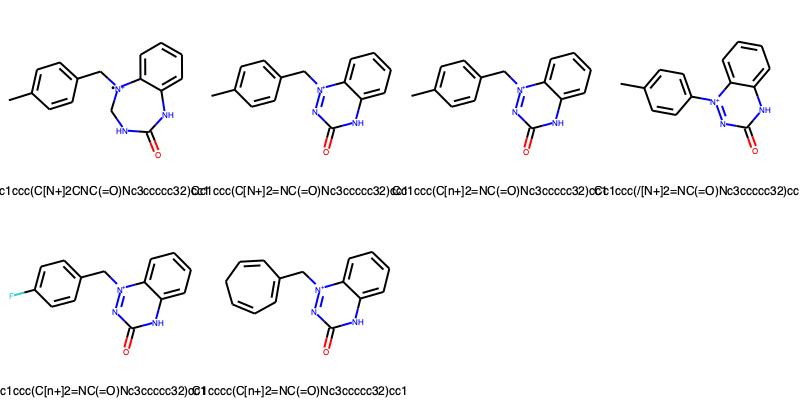

                               smiles   distance  count  frequency  \
0  Cc1ccc(C[N+]2CNC(=O)Nc3ccccc32)cc1   5.310759      1       0.04   
1  Cc1ccc(C[N+]2=NC(=O)Nc3ccccc32)cc1  10.718426      9       0.36   
2  Cc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1  10.718426      9       0.36   
3  Cc1ccc(/[N+]2=NC(=O)Nc3ccccc32)cc1  10.802370      1       0.04   
4  Fc1ccc(C[n+]2=NC(=O)Nc3ccccc32)cc1  14.074542      1       0.04   

                                                 mol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...  


In [78]:
decode_encode_properties_several_attempts(smiles[0], 2)

Searching molecules randomly sampled from 5.00 std (z-distance) from the point
Found 2 unique mols, out of 5
SMILES
 0    CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
1    CN(C1cccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C
Name: smiles, dtype: object


RDKit ERROR: [16:54:00] SMILES Parse Error: syntax error while parsing: CO-]c1ccc2c(c1)C(=O)C@H2C(=O)OC(C)(C)C
RDKit ERROR: [16:54:00] SMILES Parse Error: Failed parsing SMILES 'CO-]c1ccc2c(c1)C(=O)C@H2C(=O)OC(C)(C)C' for input: 'CO-]c1ccc2c(c1)C(=O)C@H2C(=O)OC(C)(C)C'


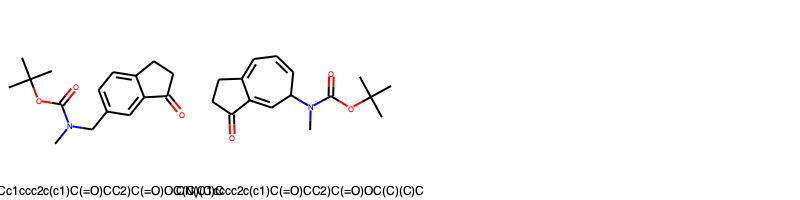

                                   smiles   distance  count  frequency  \
0  CN(Cc1ccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C   0.000006      1        0.2   
1  CN(C1cccc2c(c1)C(=O)CC2)C(=O)OC(C)(C)C  18.270672      4        0.8   

                                                 mol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  


In [64]:
decode_encode_properties_several_attempts(smiles[1], 5)

Searching molecules randomly sampled from 3.00 std (z-distance) from the point
Found 11 unique mols, out of 122
SMILES
 0     COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1
1     COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NO)cn2)CC1
2     COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)NN)cn2)CC1
3     COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)nn2)CC1
4     COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NN)cn2)CC1
5     COC(=O)C1CC(CNc2ccc(NC(=O)C(=O)NN)cn2)CC1
6     COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)cn2)CC1
7      COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NC)cn2)C1
8     COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)NC)cn2)CC1
9     COC(=O)C1CC(COc2ccc(NC(=O)C(=O)N)Ncn2)CC1
10    COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NC)nn2)CC1
Name: smiles, dtype: object


RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [16:42:22] SMILES Parse Error: syntax error while parsing: COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@1
RDKit ERROR: [16:42:22] SMILES Parse Error: Failed parsing SMILES 'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@1' for input: 'COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)C@1'
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 21
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 5 6 7
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11 12 20
RDKit ERROR: 
RDKit ERROR: [16:42:22] Can't kekulize mol.  Unkekulized atoms: 9 10 11
RDKit ERROR: 

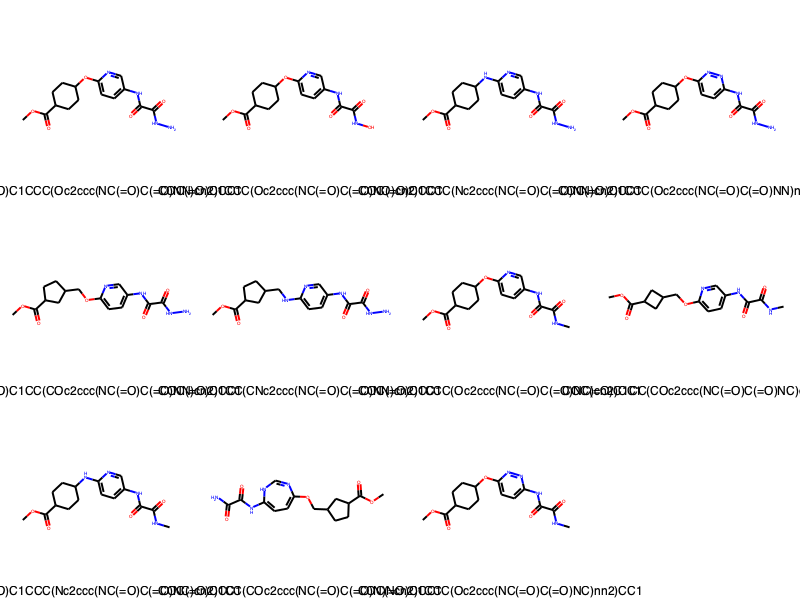

                                      smiles  distance  count  frequency  \
0  COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)cn2)CC1  0.000007     95   0.778689   
1  COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NO)cn2)CC1  2.037784      1   0.008197   
2  COC(=O)C1CCC(Nc2ccc(NC(=O)C(=O)NN)cn2)CC1  2.772173      2   0.016393   
3  COC(=O)C1CCC(Oc2ccc(NC(=O)C(=O)NN)nn2)CC1  3.373859      1   0.008197   
4  COC(=O)C1CC(COc2ccc(NC(=O)C(=O)NN)cn2)CC1  8.877530      3   0.024590   

                                                 mol  
0  <img data-content="rdkit/molecule" src="data:i...  
1  <img data-content="rdkit/molecule" src="data:i...  
2  <img data-content="rdkit/molecule" src="data:i...  
3  <img data-content="rdkit/molecule" src="data:i...  
4  <img data-content="rdkit/molecule" src="data:i...  


In [51]:
decode_encode_properties_several_attempts(smiles[2])